In [1]:
import GOES as GOES
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import pandas as pd

# import cartopy.crs as ccrs
import numpy as np
# from cartopy.feature import NaturalEarthFeature

In [2]:
# download the data
flist_cth = GOES.download('goes16', 'ABI-L2-ACHAF', # see https://www.noaa.gov/organization/information-technology/list-of-big-data-program-datasets for product names
                      DateTimeIni = '20200101-153000', DateTimeFin = '20200101-155000', 
#                       channel = ['13'],
                      path_out='./data/')

flist_cod = GOES.download('goes16', 'ABI-L2-CODF', # see https://www.noaa.gov/organization/information-technology/list-of-big-data-program-datasets for product names
                      DateTimeIni = '20200101-153000', DateTimeFin = '20200101-155000', 
#                       channel = ['13'],
                      path_out='./data/')

Files:
  OR_ABI-L2-ACHAF-M6_G16_s20200011530217_e20200011539525_c20200011541391.nc 100% 1.5MB 1s
  OR_ABI-L2-ACHAF-M6_G16_s20200011540217_e20200011549525_c20200011551340.nc 100% 1.5MB 1s
Files:
  OR_ABI-L2-CODF-M6_G16_s20200011530217_e20200011539525_c20200011541483.nc 100% 7.4MB 3s
  OR_ABI-L2-CODF-M6_G16_s20200011540217_e20200011549525_c20200011551394.nc 100% 7.4MB 3s


In [3]:
file_cth = flist_cth[0]
file_cod = flist_cod[0]

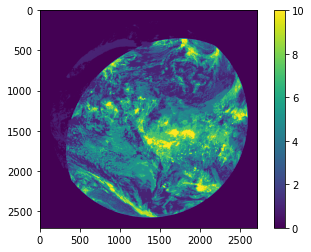

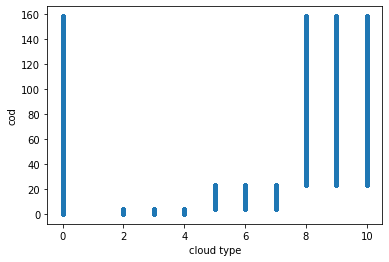

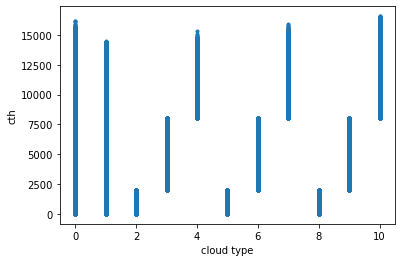

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [4]:
# reads the file using xarray
ds_cod = xr.open_dataset(file_cod)
ds_cth_coarse = xr.open_dataset(file_cth)

# get image with the coordinates of corners of their pixels
# -> Figure out later

# interpolate ds_cod such that points overlap
ds_cth = ds_cth_coarse.interp(x=ds_cod.x, y=ds_cod.y)

def classifyISCCP(cod, cth, dqf_cod, bound = [3.6, 23, 2e3, 8e3]):
    """
    Function to classify pixels based on cod and cth. 
    cod, cth, dqf_cod should all be of the same shape. 
    input: cod : (mxn) - array.  cloud optical depth
           cth : (mxn) - array.  cloud top height
           dqf_cod: (mxn) - array. data quality flags for cod data. 6 for clear sky, 0 for good quality. 
    
    bound = [lower split value cod, upper split value cod, 
                lower split value cth, upper split value cth ]
    output: ct : (mxn) - array. contains cloud classes indicated by
                0 - invalid pixel
                1 - clear sky
                2 - cumulus
                3 - altocumulus
                4 - cirrus
                5 - stratocumulus
                6 - altostratus
                7 - cirrostratus
                8 - stratus
                9 - nimbostratus
                10 - deep convection
    """
    b_cod = bound[:2]
    b_cth = bound[2:]
    ct = np.where(dqf_cod == 6, 1, # clear sky # should we also use dqf_cth = 4 here?
              np.where(dqf_cod != 0, 0, # non valid data
                       np.where(cod < b_cod[0] , 
                                np.where(cth<b_cth[0], 2,
                                        np.where(cth< b_cth[1], 3, 4)),
                       np.where(cod< b_cod[1] , 
                                np.where(cth<b_cth[0], 5,
                                        np.where(cth< b_cth[1], 6, 7)
                                        ), 
                                np.where(cth<b_cth[0], 8,
                                        np.where(cth< b_cth[1], 9, 10)
                                        )
                               )
                               )
                      )
             )
    return ct

ct = classifyISCCP(ds_cod.COD, ds_cth.HT, ds_cod.DQF)
# add classification to x_array
# ds_cth.assign(CT = ct)
# clearsky

plt.imshow(ct)
plt.colorbar()
plt.show()

plt.plot(ct.flatten(), ds_cod.COD.data.flatten(), '.')
plt.xlabel('cloud type')
plt.ylabel('cod')
plt.show()

plt.plot(ct.flatten(), ds_cth.HT.data.flatten(), '.')
plt.xlabel('cloud type')
plt.ylabel('cth')
plt.show()
np.unique(ct)

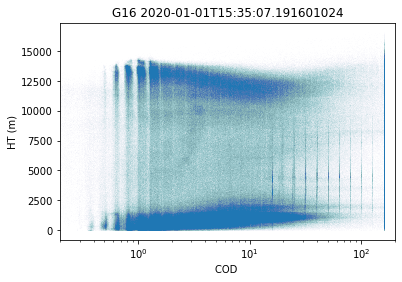

In [5]:
plt.scatter(ds_cod.COD.data.flatten(), ds_cth.HT.data.flatten(), alpha = .01, s = .1)
plt.title(f'{ds_cod.platform_ID} {ds_cod.t.data}')
plt.xlabel(f'COD ')
plt.ylabel(f'HT ({ds_cth.HT.units})')
plt.xscale('log')
plt.xlim([.2, 200])
plt.show()

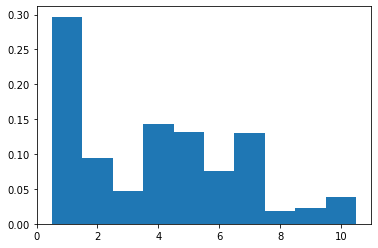

In [6]:
def histClassifications(ct):
    bins = np.linspace(0.5, 10.5, 11)
    return plt.hist(ct.flatten(), bins = bins, density = True)
    
histClassifications(ct)    
plt.show()

Try to get the right domain

In [11]:

def makeXArrayFromNetCDFs(file_cod, file_cth,
                          domain = [-50.0,-30.0,-5.0,15.0] # [left, right, bottom, top]
                         ):
    """
    function which makes from the two seperate files for cod and cth one xarray which containts cod, cth and the cloud classification
    input: file_cod    NETCDF from NOAA which contains the COD data
           file_cth    NETCDF from NOAA which contanis the CTH data
           [domain]    array (4,) which contains the extent of the area of interest
                                [left, right, bottom, top]
    output: xarray     xarray : variables - cth, cod, ct (cloud types)
                                coordinates - lat, lon, x, y
                                attribute - timestamp
    """ 
    # reads the file using xarray
    ds_cod = xr.open_dataset(file_cod)
    ds_cth_coarse = xr.open_dataset(file_cth)

    # reads the file using GOES
    ds_cod_goes = GOES.open_dataset(file_cod)
    ds_cth_goes = GOES.open_dataset(file_cth)
    
    # TODO: check same time step
#     if ds_cod.t != ds_cth.t:
#         return
    

    # get image with the coordinates of corners of their pixels
    cod, LonCor, LatCor = ds_cod_goes.image('COD', lonlat='corner', domain=domain)
    dqf_cod, LonCor, LatCor = ds_cod_goes.image('DQF', lonlat='corner', domain=domain)

    #put cod data in xarray
    xr_cod = xr.Dataset(
        data_vars=dict(
            cod=(["x", "y"], cod.data), 
            dqf_cod = (["x", "y"], dqf_cod.data)
        ),
        coords=dict(
            lon=(["x", "y"], LonCor.data[:-1, :-1]),
            lat=(["x", "y"], LatCor.data[:-1, :-1]),
            x = (["x"], np.linspace(0, 1, cod.data.shape[0])),
            y = (["y"], np.linspace(0, 1, cod.data.shape[1])),
            time=ds_cod.t.data,
        ),
        attrs = dict(extent = domain)
    )

    cth, LonCor_cth, LatCor_cth = ds_cth_goes.image('HT', lonlat='corner', domain=domain)
    # dqf_cth, LonCor, LatCor = ds_cth.image('DQF', lonlat='corner', domain=domain)
    xr_cth = xr.Dataset(
        data_vars=dict(
            cth=(["x", "y"], cth.data)
        ),
        coords=dict(
            lon=(["x", "y"], LonCor_cth.data[:-1, :-1]),
            lat=(["x", "y"], LatCor_cth.data[:-1, :-1]),
            x = (["x"], np.linspace(0, 1, cth.data.shape[0])),
            y = (["y"], np.linspace(0, 1, cth.data.shape[1])),
            time=ds_cod.t.data,
        ),
        attrs=dict(description="cth"),
    )

    # Interpolate cth such that the values are evalauted at the same locations as for cod
    image = xr_cth.interp(x=xr_cod.x, y=xr_cod.y, method = 'nearest') # deal with nans, xr.interp gives to many nan values due to interp. 
                                                                      # nearest improves some but is still quite smoothing...
    # add cod to the same xarray
    image = xr_cod.assign(cth = (["x", "y"], image.cth.data))
    
    return image

image = makeXArrayFromNetCDFs(file_cod, file_cth)
# plt.imshow(xr_cth.cth)
# plt.show()
# plt.imshow(res.cth)
# plt.show()


NameError: name 'domain' is not defined

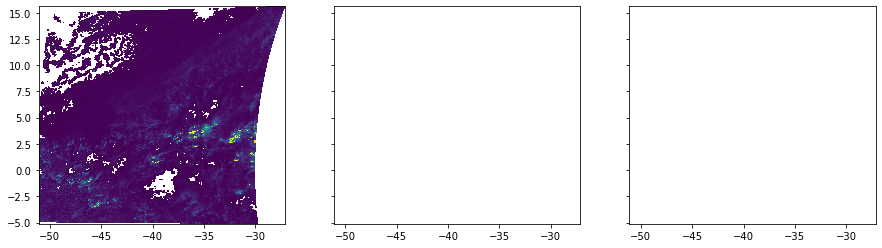

In [12]:
# Classify the clouds
ct = classifyISCCP(image.cod, image.cth, image.dqf_cod)
image = image.assign(ct = (["x", "y"], ct))

def plotImage(image):
    fig, ax = plt.subplots(1,3, figsize = (15, 4), sharex = True, sharey = True)
    fig_cod = ax[0].pcolormesh(image.lon.data, image.lat.data, image.cod)
    ax[0].set_xlim([domain[0], domain[1]])
    ax[0].set_ylim([ domain[2], domain[3]])
    ax[0].set_title('COD')
    plt.colorbar(fig_cod, ax = ax[0])

    fig_cth = ax[1].pcolormesh(image.lon.data, image.lat.data, image.cth)
    ax[1].set_title('CTH')
    plt.colorbar(fig_cth, ax =ax[1])

    fig_ct = ax[2].pcolormesh(image.lon.data, image.lat.data, ct)
    ax[2].set_title('Classification')
    fig.colorbar(fig_ct, ax =ax[2])
    return fig

plotImage(image)
plt.show()



In [ ]:
histClassifications(ct)
plt.show()

In [14]:
# Check how large saving the image would be (without the lat, lon coordinates, because they will be the same for every image)
def saveImage(image):
    date = image.time.data
    ts = pd.to_datetime(str(date)) 
    d = ts.strftime('%Y%m%d-%Hh%M%S')
    image.drop(['lon', 'lat']).to_netcdf(f'output/image_{d}')
    
saveImage(image)

In [41]:
ds_cod.t != ds_cth.t

<xarray.DataArray 't' ()>
array(False)
Coordinates: (12/14)
    t                                   datetime64[ns] 2020-01-01T15:35:07.19...
    y_image                             float32 0.0
    x_image                             float32 0.0
    cod_product_wavelength              float32 0.64
    day_retrieval_local_zenith_angle    float32 65.0
    night_retrieval_local_zenith_angle  float32 90.0
    ...                                  ...
    night_solar_zenith_angle            float32 90.0
    twilight_solar_zenith_angle         float32 77.5
    day_algorithm_solar_zenith_angle    float32 82.0
    night_algorithm_solar_zenith_angle  float32 82.0
    local_zenith_angle                  float32 ...
    solar_zenith_angle                  float32 ...

In [17]:
# Perform function to go from downloaded data to image with correct domain and classification in netcdf file
def rawDatatoClassification(flist_cth, flist_cod):
    
    for i in range(len(flist_cth)):
        file_cth = flist_cth[i]
        file_cod = flist_cod[i]
        image = makeXArrayFromNetCDFs(file_cod, file_cth)
        ct = classifyISCCP(image.cod, image.cth, image.dqf_cod)
        image = image.assign(ct = (["x", "y"], ct))
    #     print(image.time.data)
    #     plotImage(image)
    #     plt.show()
        saveImage(image)
    return image

rawDatatoClassification(flist_cth, flist_cod)


<xarray.Dataset>
Dimensions:  (x: 535, y: 430)
Coordinates:
    lon      (x, y) float32 -50.0 -49.95 -49.91 -49.87 ... -29.91 -29.85 -29.79
    lat      (x, y) float32 15.0 15.0 15.0 15.0 ... -5.12 -5.121 -5.122 -5.122
  * x        (x) float64 0.0 0.001873 0.003745 0.005618 ... 0.9963 0.9981 1.0
  * y        (y) float64 0.0 0.002331 0.004662 0.006993 ... 0.9953 0.9977 1.0
    time     datetime64[ns] 2020-01-01T15:45:07.195367040
Data variables:
    cod      (x, y) float32 nan nan nan nan nan ... 1.16 0.8106 0.6348 0.8033
    dqf_cod  (x, y) float32 6.0 6.0 6.0 6.0 6.0 6.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    cth      (x, y) float32 nan nan nan nan ... 1.17e+04 1.235e+04 1.235e+04
    ct       (x, y) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 3 3 4 4 4 4 4 4 4
Attributes:
    extent:   [-50.0, -30.0, -5.0, 15.0]

Calculate Transition between subsequent images